### Load data ###

In [59]:
import pickle

with open('NBA_temporal_dataset.pkl', 'rb') as file:
    temporal_data_dict = pickle.load(file)

X_primary = temporal_data_dict['X_primary']
X_opposing = temporal_data_dict['X_opposing'] 
y = temporal_data_dict['y']

print(X_primary.shape)
print(X_opposing.shape)
print(y.shape)

(83178, 5, 42)
(83178, 5, 42)
(83178, 1)


In [60]:
import torch

X_primary_torch = torch.from_numpy(X_primary).float()
X_opposing_torch = torch.from_numpy(X_opposing).float()
y_torch = torch.from_numpy(y).float()


In [61]:
from torch.utils.data import Dataset, DataLoader

class NBADataset(Dataset):
    def __init__(self, X_primary_data, X_opposing_data, y_data):
        self.X_primary_data = X_primary_data
        self.X_opposing_data = X_opposing_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_primary_data)

    def __getitem__(self, idx):
        return self.X_primary_data[idx], self.X_opposing_data[idx], self.y_data[idx]

In [62]:
from torch.utils.data import random_split

dataset = NBADataset(X_primary_torch, X_opposing_torch, y_torch)

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [63]:
# Check if loader is loading properly

for x_primary, x_opposing, y in train_loader:
    print("Batch X_primary:", x_primary.shape)  # should be [batch_size, 5, 42]
    print("Batch X_opposing:", x_opposing.shape) # should be [batch_size, 5, 42]
    print("Batch y:", y.shape)  # should be [batch_size, 1]
    break

Batch X_primary: torch.Size([1024, 5, 42])
Batch X_opposing: torch.Size([1024, 5, 42])
Batch y: torch.Size([1024, 1])


## Create Dual LSTM module ##

In [64]:
import torch
import torch.nn as nn

class SiameseDualLSTM(nn.Module):
    def __init__(self, input_size=42, hidden_size=128, num_layers=2, dropout=0.3):
        super(SiameseDualLSTM, self).__init__()
        
        # LSTM for primary team
        self.lstm_primary = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # LSTM for opposing team
        self.lstm_opposing = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers after concatenating both LSTM outputs
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, primary_input, opposing_input):
        # Primary team LSTM
        _, (primary_out, _) = self.lstm_primary(primary_input)
        
        # Opposing team LSTM
        _, (opposing_out, _) = self.lstm_opposing(opposing_input)
        
        # Concatenate the final hidden states from both LSTMs (batch_size, hidden_size*2)
        combined = torch.cat((primary_out[-1], opposing_out[-1]), dim=1)
        
        # Feed through fully connected layers
        x = self.fc1(combined)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        
        #Using BCE with Logits, no need for sigmoid
        return x



In [65]:
# Function to train and test model 
import time


def AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    time_to_train_per_epoch_list = []

    model.to(device)

    for epoch in range(epochs):
        # Set current epoch train loss, train accuracy and test accuracy to 0.0
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0
        time_per_epoch = 0.0
        # Put model in training mode
        model.train()
        start_time = time.time()
        for X_primary_batch, X_opposing_batch, y_batch in train_loader:
            X_primary_batch = X_primary_batch.to(device)
            X_opposing_batch = X_opposing_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_primary_batch, X_opposing_batch)
            # Get loss on current batch
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # Accumulate train loss in epoch
            train_loss += loss.item()
        # Add train loss to train_losses, in order to track
        # print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
        train_losses.append(train_loss)
        end_time = time.time()
        
        # Calculate time per epoch and accumulate
        time_per_epoch = end_time - start_time
        time_to_train_per_epoch_list.append(time_per_epoch)
        
        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over train dataset, in order to get accuracy for model at current epoch
            for X_primary_batch, X_opposing_batch, y_batch in train_loader:
                X_primary_batch = X_primary_batch.to(device)
                X_opposing_batch = X_opposing_batch.to(device)

                y_pred = model(X_primary_batch, X_opposing_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float().round()
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add train accuracy to train_accuracies
        train_acc = correct / total
        print(f"Epoch {epoch+1}, Training Accuracy: {train_acc}")
        train_accuracies.append(train_acc)

        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over test dataset, in order to get accuracy for model at current epoch
            for X_primary_batch, X_opposing_batch, y_batch in test_loader:
                X_primary_batch = X_primary_batch.to(device)
                X_opposing_batch = X_opposing_batch.to(device)

                y_pred = model(X_primary_batch, X_opposing_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float()
                
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add test accuracy to test_accuracies
        test_acc = correct / total
        print(f"Epoch {epoch+1}, Test Accuracy: {test_acc}")
        test_accuracies.append(test_acc)

    return train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list

In [66]:
# initialize model, optimizer and loss function

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SiameseDualLSTM(input_size=42, hidden_size=128, num_layers=2, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [67]:
# Train and test model 
train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list = AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = 100)

Epoch 1, Training Accuracy: 0.585928858823718
Epoch 1, Test Accuracy: 0.5838422697763885
Epoch 2, Training Accuracy: 0.6013817867047112
Epoch 2, Test Accuracy: 0.5999519115171916
Epoch 3, Training Accuracy: 0.6006764663449978
Epoch 3, Test Accuracy: 0.5989901418610243
Epoch 4, Training Accuracy: 0.6066877194107368
Epoch 4, Test Accuracy: 0.6064438566963213
Epoch 5, Training Accuracy: 0.612490582370197
Epoch 5, Test Accuracy: 0.6101466698725655
Epoch 6, Training Accuracy: 0.6122982222720934
Epoch 6, Test Accuracy: 0.6107718201490743
Epoch 7, Training Accuracy: 0.613227962746261
Epoch 7, Test Accuracy: 0.610339023803799
Epoch 8, Training Accuracy: 0.6141096131959027
Epoch 8, Test Accuracy: 0.6106756431834576
Epoch 9, Training Accuracy: 0.613596652934293
Epoch 9, Test Accuracy: 0.6107237316662659
Epoch 10, Training Accuracy: 0.6149592036291939
Epoch 10, Test Accuracy: 0.6115412358740082
Epoch 11, Training Accuracy: 0.611432601830627
Epoch 11, Test Accuracy: 0.6087040153883145
Epoch 12, Tr

Total time to train model: 497.7761974334717
Number of epochs:  100
Average time per epoch:  4.977761974334717


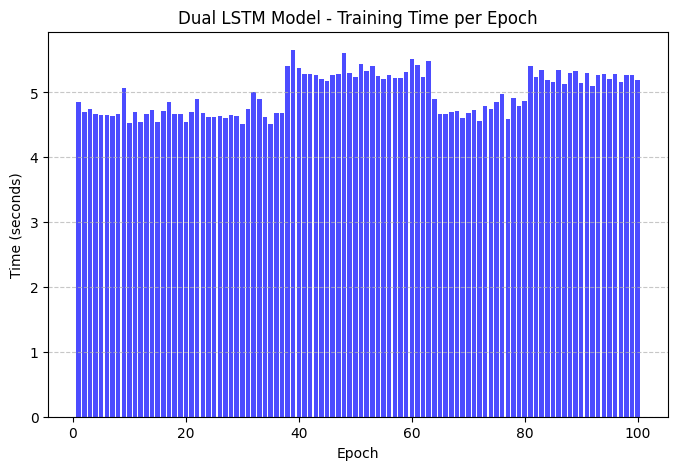

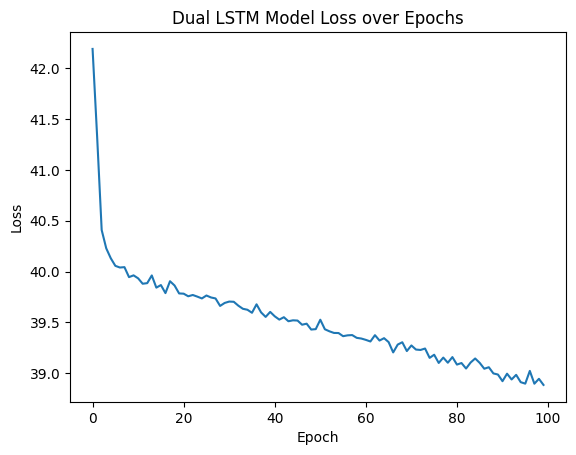

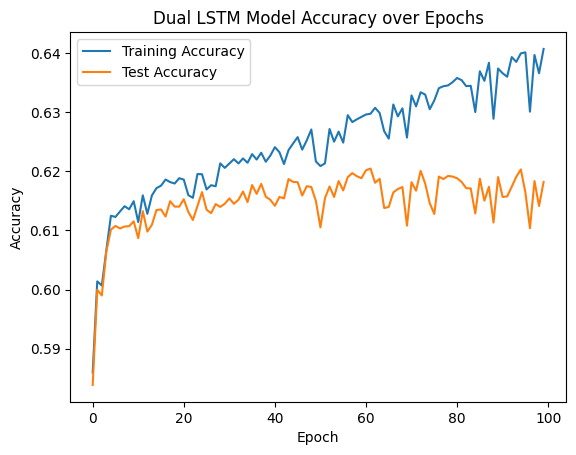

In [68]:
import matplotlib.pyplot as plt

def plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, model_name):

    print(f"Total time to train model: {sum(time_to_train_per_epoch_list)}")

    print("Number of epochs: ", len(time_to_train_per_epoch_list))

    print("Average time per epoch: ", sum(time_to_train_per_epoch_list) / len(time_to_train_per_epoch_list))

    epochs = list(range(1, len(time_to_train_per_epoch_list) + 1))  # Epoch numbers

    plt.figure(figsize=(8, 5))
    plt.bar(epochs, time_to_train_per_epoch_list, color='blue', alpha=0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title(f"{model_name} - Training Time per Epoch")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(model_name + " Loss over Epochs")
    plt.show()

    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(model_name + " Accuracy over Epochs")
    plt.show()

plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, "Dual LSTM Model")

In [69]:
# Function for evaluating model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_ffn_classifier(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_primary_batch, X_opposing_batch, y_batch in test_loader:
            X_primary_batch = X_primary_batch.to(device)
            X_opposing_batch = X_opposing_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_primary_batch, X_opposing_batch).squeeze()
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs >= 0.5).int().cpu().numpy())
            all_labels.extend(y_batch.int().cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_prediction_distribution_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_primary_batch, X_opposing_batch, y_batch in test_loader:
            X_primary_batch = X_primary_batch.to(device)
            X_opposing_batch = X_opposing_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_primary_batch, X_opposing_batch).squeeze()
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels).ravel()

    true_win_probs = all_probs[all_labels == 1]
    true_loss_probs = all_probs[all_labels == 0]

    plt.figure(figsize=(8, 5))
    sns.histplot(true_win_probs, color="green", label="True Wins", kde=True, stat="density", bins=30)
    sns.histplot(true_loss_probs, color="red", label="True Losses", kde=True, stat="density", bins=30)

    plt.title(f"{model_name} – Probability Distribution of Predicted Wins")
    plt.xlabel("Predicted Probability of Win")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_roc_curve_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_primary_batch, X_opposing_batch, y_batch in test_loader:
            X_primary_batch = X_primary_batch.to(device)
            X_opposing_batch = X_opposing_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_primary_batch, X_opposing_batch).squeeze()
            
            probs = torch.sigmoid(logits)  # convert logits to probabilities
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Evaluation for Dual LSTM
Accuracy     : 0.6182
Precision    : 0.6152
Recall       : 0.6032
F1 Score     : 0.6091
ROC-AUC Score: 0.6635

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.63      0.63     10539
           1       0.62      0.60      0.61     10256

    accuracy                           0.62     20795
   macro avg       0.62      0.62      0.62     20795
weighted avg       0.62      0.62      0.62     20795



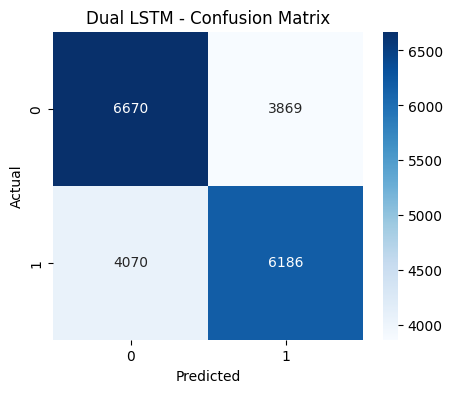

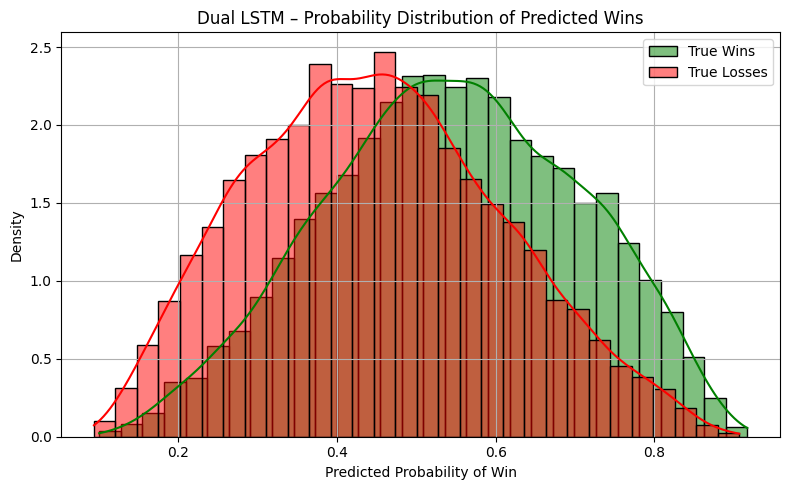

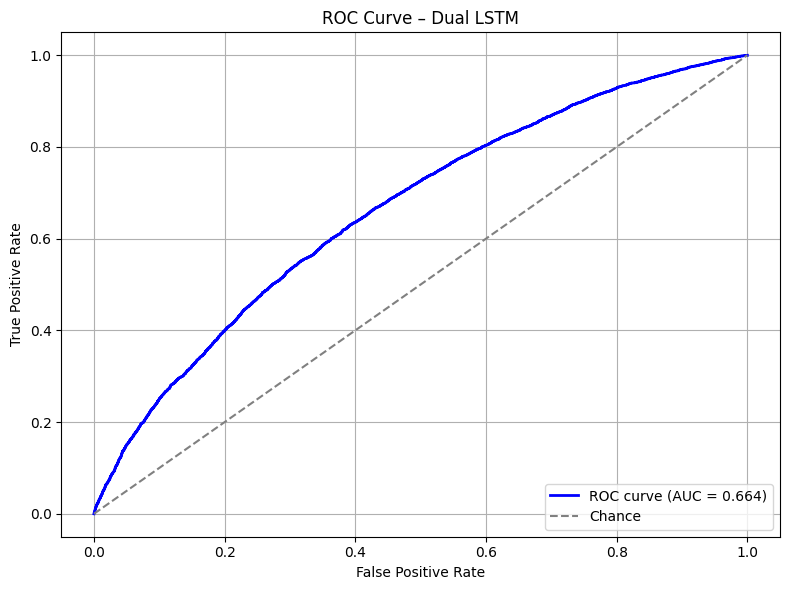

In [70]:
evaluate_ffn_classifier(model, test_dataset, model_name="Dual LSTM")
plot_prediction_distribution_ffn(model, test_dataset, model_name="Dual LSTM")
plot_roc_curve_ffn(model, test_dataset, model_name="Dual LSTM")

### Save the model ###

In [71]:
import os

# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)

path = os.path.join('.', 'models', 'dual_lstm_model.pth')

# Save the model's state_dict
torch.save(model.state_dict(), path)

In [72]:
import os

# Load the model's state_dict

model = SiameseDualLSTM(input_size=42, hidden_size=128, num_layers=2, dropout=0.3)
path = os.path.join('.', 'models', 'dual_lstm_model.pth')
model.load_state_dict(torch.load(path))
model.eval()

C:\Users\Alex1\AppData\Local\Temp\ipykernel_56208\3504842617.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


SiameseDualLSTM(
  (lstm_primary): LSTM(42, 128, num_layers=2, batch_first=True, dropout=0.3)
  (lstm_opposing): LSTM(42, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [75]:
print(train_accuracies)
print(test_accuracies)
print(time_to_train_per_epoch_list)

[0.585928858823718, 0.6013817867047112, 0.6006764663449978, 0.6066877194107368, 0.612490582370197, 0.6122982222720934, 0.613227962746261, 0.6141096131959027, 0.613596652934293, 0.6149592036291939, 0.611432601830627, 0.6159530641360627, 0.6128272125418784, 0.6159370341278874, 0.6171713447573858, 0.6175881249699438, 0.6186300755013385, 0.6181972652806053, 0.6179568151579757, 0.6188544956157928, 0.6186140454931632, 0.6159690941442381, 0.6155362839235048, 0.6195598159755061, 0.6195277559591555, 0.6169469246429315, 0.6176682750108202, 0.6174919449208919, 0.6213712068993155, 0.6206017665069009, 0.6213391468829649, 0.622076527259029, 0.6213551768911402, 0.6222047673244313, 0.6214673869483673, 0.62292611769232, 0.6220124072263277, 0.6231665678149496, 0.6216437170382957, 0.6226856675696905, 0.6241123382972925, 0.6232627478640014, 0.6212589968420884, 0.6236154080438581, 0.6247375086161294, 0.6258115191638748, 0.6236955580847346, 0.6252664988859145, 0.6271099498260744, 0.6216918070628216, 0.62090

In [77]:
import csv

def save_training_stats_to_csv(filename, train_acc, test_acc, train_loss, time_per_epoch):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Accuracy", "Test Accuracy", "Train Loss", "Time per Epoch (s)"])

        for epoch in range(len(train_acc)):
            writer.writerow([
                epoch + 1,
                train_acc[epoch],
                test_acc[epoch],
                train_loss[epoch],
                time_per_epoch[epoch]
            ])


save_training_stats_to_csv(
    os.path.join('.', 'training_data' ,'dual_lstm.csv'),
    train_accuracies,
    test_accuracies,
    train_losses,
    time_to_train_per_epoch_list
)